In [1]:
!pip install scikit-learn


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [3]:
#dataset address https://drive.google.com/file/d/1MqY9yaql1XQbodFSngsHxGbyLdWRhVXj/view?usp=sharing
data = pd.read_csv('AMZN.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [4]:
data = data[['Date', 'Close']]
data

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354
...,...,...
6511,2023-03-30,102.000000
6512,2023-03-31,103.290001
6513,2023-04-03,102.410004
6514,2023-04-04,103.949997


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

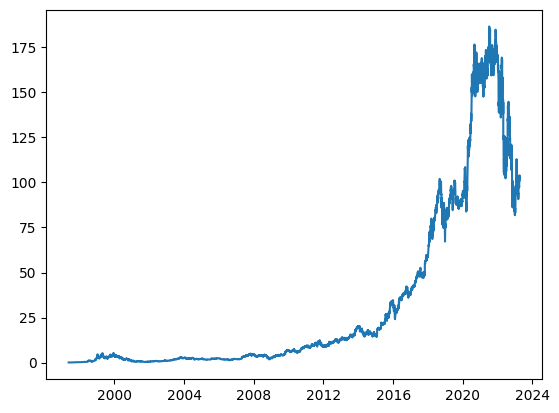

In [6]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data["Date"], data["Close"])

In [7]:
#@title Shift the data, so it's sequential 7 days back
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    new_df = dc(df)

    new_df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        new_df[f'Close(t-{i})'] = new_df['Close'].shift(i)
        # it appends new columns to the dataframe iteratively

    new_df.dropna(inplace=True)
    return new_df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2023-03-30,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001
2023-03-31,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997
2023-04-03,102.410004,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999


In [8]:
data_np = shifted_df.to_numpy()
data_np

array([[7.91670000e-02, 7.50000000e-02, 6.97920000e-02, ...,
        8.54170000e-02, 8.64580000e-02, 9.79170000e-02],
       [7.65630000e-02, 7.91670000e-02, 7.50000000e-02, ...,
        8.17710000e-02, 8.54170000e-02, 8.64580000e-02],
       [7.52600000e-02, 7.65630000e-02, 7.91670000e-02, ...,
        7.13540000e-02, 8.17710000e-02, 8.54170000e-02],
       ...,
       [1.02410004e+02, 1.03290001e+02, 1.02000000e+02, ...,
        9.80400010e+01, 9.81299970e+01, 9.87099990e+01],
       [1.03949997e+02, 1.02410004e+02, 1.03290001e+02, ...,
        9.72399980e+01, 9.80400010e+01, 9.81299970e+01],
       [1.01099998e+02, 1.03949997e+02, 1.02410004e+02, ...,
        1.00250000e+02, 9.72399980e+01, 9.80400010e+01]])

In [9]:
data_np[0].shape

(8,)

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
data_np = scaler.fit_transform(data_np)

data_np

array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.09747299,  0.10690997,  0.09308121, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.11398769,  0.09747299,  0.10691495, ...,  0.04203581,
         0.0506149 ,  0.05158   ],
       [ 0.08342464,  0.11398769,  0.09747802, ...,  0.07431453,
         0.04203581,  0.0506149 ]])

In [11]:
X = data_np[:, 1:]
y = data_np[:, 0]

X.shape, y.shape

((6509, 7), (6509,))

In [12]:
X = dc(np.flip(X, axis=1)) ## reverse the order of days in shifted dataset
X                          ## so that older days come first

array([[-0.99969839, -0.99982128, -0.99983244, ..., -0.99998325,
        -1.        , -0.99995531],
       [-0.99982128, -0.99983244, -0.99987154, ..., -1.        ,
        -0.99994415, -0.99991063],
       [-0.99983244, -0.99987154, -0.99998325, ..., -0.99994415,
        -0.99989946, -0.99993855],
       ...,
       [ 0.05779984,  0.05158   ,  0.0506149 , ...,  0.07431453,
         0.09308121,  0.10690997],
       [ 0.05158   ,  0.0506149 ,  0.04203581, ...,  0.09308121,
         0.10691495,  0.09747299],
       [ 0.0506149 ,  0.04203581,  0.07431453, ...,  0.10691495,
         0.09747802,  0.11398769]])

In [13]:
#@title We gonna divide dataset on 95% train data and 5% test
split_index = int(len(X) * 0.95)
split_index

6183

In [14]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7), (326, 7), (6183,), (326,))

In [15]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7, 1), (326, 7, 1), (6183, 1), (326, 1))

In [16]:
#@title Convert data matrices into torch tensors
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()

y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6183, 7, 1]),
 torch.Size([326, 7, 1]),
 torch.Size([6183, 1]),
 torch.Size([326, 1]))

In [17]:
#@title Convert torch tensors into Dataset object
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        # write down data into class attributes

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [18]:
train_dataset = TimeSeriesDataset(X_train, y_train) # объекты Dataset, содержащие в себе все датапойнты
test_dataset = TimeSeriesDataset(X_test, y_test)

In [19]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

loader = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
    'test': DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
}
## ДатаЛоадер возвращает те самые self.X[index], self.y[index] из метода __getitem__
## но в батчах и шаффлит (перемешивает)

In [20]:
for inputs, targets in loader['train']:
    inputs, targets = inputs.to(device), targets.to(device)
    print(inputs.shape, targets.shape)
    print(inputs.size(0))
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])
16


In [21]:
# this LSTM considers only 1 input feature and it's 'Closing' value
# even though we split it into 7 columns of 7 days sequence, it's still 1 feature
class ModelLSTM(nn.Module):
    """
    params:
    input_size – The number of expected features in the input x
    hidden_size – The number of features in the hidden state h
    num_layers – Number of recurrent layers. E.g., setting num_layers=2
         would mean stacking two LSTMs together to form a stacked LSTM,
         with the second LSTM taking in outputs of the first LSTM
         and computing the final results. Default: 1"""

    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)
        # as batch_first=True, batch_size comes first in input dimentionality, otherwise sequence_length comes first in LSTM layers inputs
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        # initialize hidden state and cell state of LSTM with zeros
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        # LSTM input dimentions with batch_first=True [batch_size, sequence_length, input_size]
        # LSTM output dimentionality is [batch_size, sequence_length, hidden_size]
        # Output shape of LSTM layer: torch.Size([16, 7, 4])
        out, _ = self.lstm(x, (h0, c0))
        # lstm takes as input and gives as output cell and hidden states
        # it outputs them so we can pass those vectors elsewhere
        out = self.fc(out[:, -1, :])
        # since sequence length is 7, LSTM outputs predictions for 7 last days
        # but we need only 1 last day, so we pick last hidden state vectors
        # so, the shape of input for linear layer is [16, 4] - 16 samples of 4-sized vectors

        return out

In [22]:
model = ModelLSTM(1, 4, 1)
model.to(device)
model

ModelLSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [23]:
rnn = nn.LSTM(input_size=1, hidden_size=4, num_layers=1, batch_first=True)
input = torch.randn(16, 7, 1) #batch_size=16, sequence_length=7, num_features=1
h0 = torch.zeros(1, 16, 4) # num_layers=1, batch_size=16, hidden_size=4
c0 = torch.zeros(1, 16, 4)
output, (hn, cn) = rnn(input, (h0, c0))
output.shape, hn.shape, cn.shape, output[:, -1, :].shape

(torch.Size([16, 7, 4]),
 torch.Size([1, 16, 4]),
 torch.Size([1, 16, 4]),
 torch.Size([16, 4]))

In [24]:
print(output)
print(output[:, -1, :])

tensor([[[-1.4024e-02,  1.7026e-01,  1.7097e-01, -1.7388e-01],
         [-2.6167e-02,  2.3282e-01,  2.2680e-01, -2.5974e-01],
         [ 3.9755e-02,  7.2875e-02,  1.1617e-01, -1.5785e-01],
         [-1.9781e-04,  1.7657e-01,  1.6930e-01, -3.0688e-01],
         [ 5.2264e-02,  8.5259e-02,  1.0990e-01, -2.0670e-01],
         [ 3.2690e-02,  1.2212e-01,  1.2053e-01, -2.7332e-01],
         [ 1.7236e-02,  1.5124e-01,  1.4194e-01, -2.9925e-01]],

        [[-2.2483e-03,  1.2664e-01,  1.0807e-01, -1.6468e-01],
         [-1.0055e-02,  1.8062e-01,  1.5458e-01, -2.4684e-01],
         [ 3.6387e-02,  9.8553e-02,  1.0437e-01, -1.9647e-01],
         [ 4.5998e-02,  1.0098e-01,  1.0057e-01, -2.3388e-01],
         [ 5.9234e-02,  8.8724e-02,  9.5482e-02, -2.3477e-01],
         [ 3.0252e-02,  1.3254e-01,  1.2572e-01, -2.9007e-01],
         [ 2.5646e-02,  1.3710e-01,  1.3102e-01, -2.8310e-01]],

        [[ 3.8291e-02,  4.8431e-02,  4.7747e-02, -1.2883e-01],
         [ 9.9586e-02,  2.0621e-02,  4.9789e-02, -1

In [25]:
print(torch.randn(16, 7, 1).shape)
print(torch.zeros(16, 7, 1).shape)



torch.Size([16, 7, 1])
torch.Size([16, 7, 1])


In [35]:
def train():
    epoch_loss = 0
    model.train()

    for batch_id, (X, y) in enumerate(loader['train']):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(X)          # forward pass
        loss = LOSS(y, out)     # calculate loss
        loss.backward()         # backprop
        optimizer.step()        # update weights

        epoch_loss += loss.item()

    epoch_loss /= len(loader['train'])
    # print(f'Train epoch: {epoch+1}, Loss: {epoch_loss}')

    return epoch_loss

def val():
    epoch_loss = 0
    model.train(False)


    for X, y in loader['test']:
        X, y = X.to(device), y.to(device)

        with torch.no_grad():
            out = model(X)
            loss = LOSS(out, y)

            epoch_loss += loss.item()

    epoch_loss /= len(loader['test'])
    # print(f'Evaluation loss: {epoch_loss}')

    return epoch_loss

In [36]:
EPOCHS = 15
LOSS = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

train_loss_history = []
val_loss_history = []


for epoch in range(EPOCHS):
    train_loss = train()
    val_loss = val()

    print(f'Train epoch: {epoch+1}, Loss: {train_loss:.4}, Val_loss:{val_loss:.4}')

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

Train epoch: 1, Loss: 0.0001197, Val_loss:0.001623
Train epoch: 2, Loss: 0.000121, Val_loss:0.00187
Train epoch: 3, Loss: 0.000118, Val_loss:0.001541
Train epoch: 4, Loss: 0.0001185, Val_loss:0.001673
Train epoch: 5, Loss: 0.0001134, Val_loss:0.001865
Train epoch: 6, Loss: 0.0001189, Val_loss:0.001546
Train epoch: 7, Loss: 0.0001197, Val_loss:0.001546
Train epoch: 8, Loss: 0.0001158, Val_loss:0.001606
Train epoch: 9, Loss: 0.0001221, Val_loss:0.00191
Train epoch: 10, Loss: 0.0001176, Val_loss:0.001879
Train epoch: 11, Loss: 0.0001146, Val_loss:0.001706
Train epoch: 12, Loss: 0.0001185, Val_loss:0.001525
Train epoch: 13, Loss: 0.0001162, Val_loss:0.001552
Train epoch: 14, Loss: 0.0001151, Val_loss:0.001532
Train epoch: 15, Loss: 0.0001188, Val_loss:0.001538


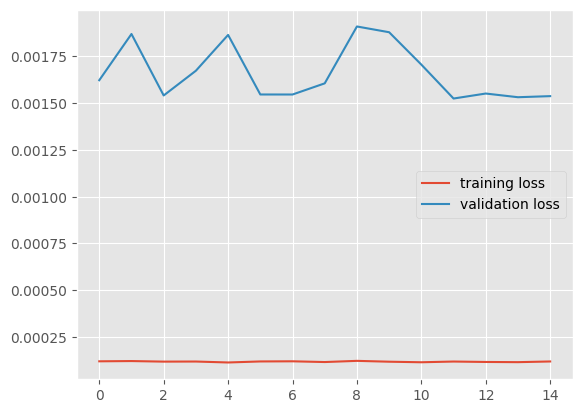

In [37]:
plt.style.use('ggplot')
plt.plot(train_loss_history, label='training loss')
plt.plot(val_loss_history, label='validation loss')
plt.legend()
plt.show()

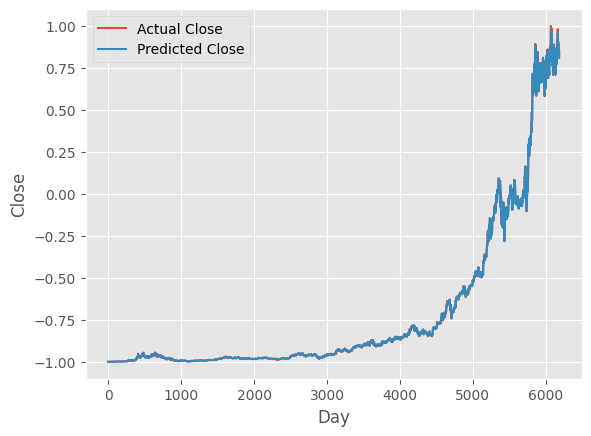

In [38]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

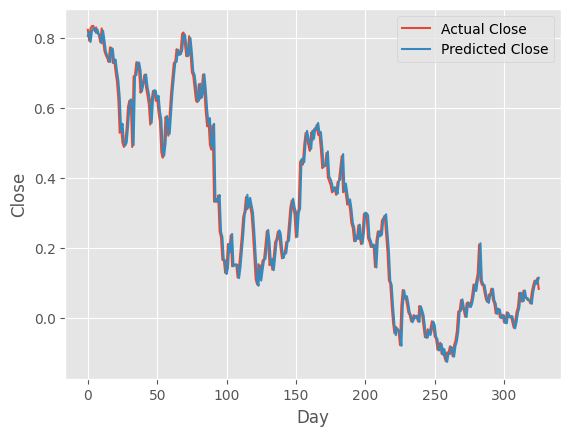

In [39]:
with torch.no_grad():
    predicted = model(X_test.to(device)).to('cpu').numpy()

plt.plot(y_test, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [50]:
predictions = predicted.flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = predictions
dummies = scaler.inverse_transform(dummies)

predictions = dc(dummies[:, 0])
predictions[:10]

array([168.44645709, 169.46579463, 166.80565469, 169.79180078,
       170.38760935, 170.42779458, 169.19037852, 170.07613213,
       168.74895238, 168.21316043])

In [49]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test[:10]

array([170.01749949, 167.07899763, 170.41700626, 171.03700377,
       171.0684961 , 169.66949429, 170.66099675, 169.20100565,
       168.64449858, 166.71699707])

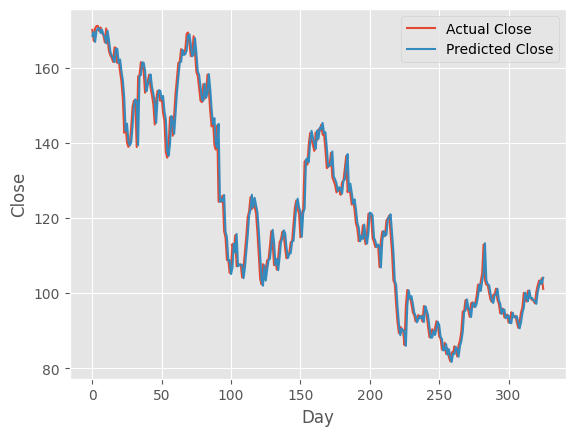

In [46]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [47]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([7.91646265e-02, 7.65634249e-02, 7.52572660e-02, ...,
       1.69091505e+02, 1.73315001e+02, 1.68871003e+02])

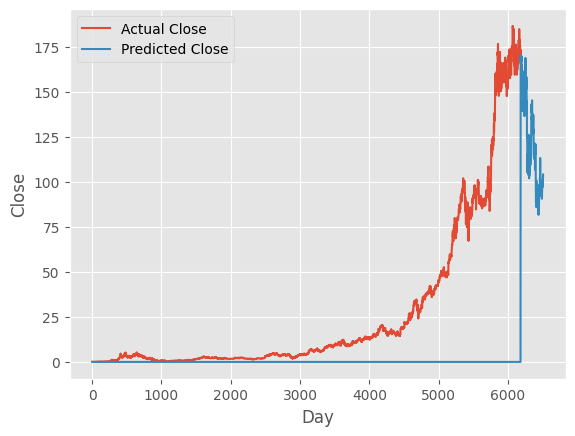

In [53]:
dummy_vector = np.zeros(new_y_train.shape)
predictions = np.concatenate((dummy_vector, predictions))

plt.plot(new_y_train, label='Actual Close')
plt.plot(predictions, label='Predicted Close')

plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()